# CNN + MaxPool
Same as CNN_264 which achieved about 60% accuracy on all cell lines except H1.hESC. 

Here, run the same model on all cell lines. Exclude none.

In [1]:
from datetime import datetime
print(datetime.now())

2023-03-26 18:51:59.409992


In [2]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
# tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
print(DATA_DIR)

Found GPU at: /device:GPU:0
Running on CoLab
Mounted at /content/drive/
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [3]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=4
CFILTERS=64 
FILTERSIZE=8
RCELLS=32
DCELLS=16
EPOCHS=8 # 20 
EMBED_DIMEN = 4 # arbitrary hyperparameter
# MINLEN=200   # NO LONGER USED
MAXLEN=5000   
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'ZERO'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
NUM_CELL_LINES=15
EXCLUSIONS = set()   # exclude none
print('Exclusions:',EXCLUSIONS)

Python 3.9.16
sklearn 1.2.2
Exclusions: set()


In [4]:
RCI_FILE_TRAIN = 'train.lncRNA_RCI.csv'
RCI_FILE_VALID = 'train.lncRNA_RCI.csv'
RCI_FILE_TEST  = None # else 'test.lncRNA_RCI.csv'

SEQ_FILE_TRAIN = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_VALID = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_TEST  = None # else 'test.canon_lncRNA_transcripts.csv'

In [5]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

## Data Load

In [6]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        self.gene2rci = dict()
        
    def load_gene_rci_values(self,filepath,exclusions):
        '''
        Load all the genes from the given RCI csv file.
        The given file usually contains train or test, not both.
        Load average RCI for each across cell lines.
        Define average as log of mean of antilogs: log2(mean(2^RCI)).
        Return dict with keys=gene:str and values=RCI:float.
        '''
        self.gene2rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    cell_line_index = 0
                    rci_values = []
                    log_mean=0.0
                    for rci_str in fields:
                        if cell_line_index not in exclusions:
                            if rci_str != "nan":
                                rci_val = float(rci_str)
                                rci_values.append(rci_val)
                        cell_line_index += 1
                    if len(rci_values)>0:
                        values = np.array(rci_values)
                        antilogs = [2**x for x in values]
                        big_mean = np.mean(antilogs)
                        if np.absolute(big_mean)<0.000001:
                            log_mean = -1000000 # neg infinity
                        else:
                            log_mean = np.log2(big_mean) 
                        self.gene2rci[gene_id] = log_mean
                    # TO DO: get rid of this check on our log/antilog arithmetic.
                    if len(rci_values)==1:
                        diff = rci_values[0]-log_mean
                        if diff>0.000001:
                            print('antilog',log_mean,'not equal',rci_values,'for gene',gene_id)
        print('Number of RCI values loaded',len(self.gene2rci.keys()))
        return self.gene2rci

    def _seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        '''
        Load all the sequences from the given file. 
        Load our version of GenCode -- csv, easier to parse than fasta.
        Each line has IDs plus sequence.
        The IDs in the file do not include dot-version numbers.
        The file may already be filtered e.g. canonical transcripts.
        '''
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # without version number
                    gene_id = fields[1]  # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    # Keep only transcripts having numeric RCI given the cell lines in use.
                    # We have validated this by spot checking.
                    # TO DO: validate this programmatically.
                    if gene_id in self.gene2rci.keys():
                        if seq_len<=MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                        seq_txt = seq_txt[:MAXLEN]
                        allids.append( (gene_id,tran_id) )
                        hot_vec = self._seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        self.cache=dict() # save RAM
        return allids,allseq

## Model

In [7]:
def build_model():
    ALPHABET=4**K+1  # NUMBER OF DISTINCT KMERS POSSIBLE, add one if N gets mask value
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    cnn = Sequential()
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,input_length=ADJUST_LENGTH,mask_zero=True)   
    cnn1_layer = Conv1D(CFILTERS, FILTERSIZE)
    pool1_layer = MaxPooling1D(pool_size=FILTERSIZE, strides=FILTERSIZE//2)
    drop1_layer = Dropout(0.5)
    cnn2_layer = Conv1D(CFILTERS, FILTERSIZE)
    pool2_layer = MaxPooling1D(pool_size=FILTERSIZE, strides=FILTERSIZE//2)
    drop2_layer = Dropout(0.5)
    flat_layer = Flatten()
    #dens_layer = Dense(DCELLS,activation='relu')
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    cnn.add(embed_layer)
    cnn.add(cnn1_layer)
    cnn.add(pool1_layer)
    cnn.add(drop1_layer)
    cnn.add(cnn2_layer)
    cnn.add(pool2_layer)
    cnn.add(drop2_layer)
    cnn.add(flat_layer)
    cnn.add(output_layer)

    # Logits=False because sigmoid output is a probability in range [0.,1.]; see
    # https://keras.io/api/losses/probabilistic_losses/#binarycrossentropy-class
    bc=BinaryCrossentropy(from_logits=False)
    cnn.compile(loss=bc, optimizer="Adam", metrics=["accuracy"])
    return cnn

In [8]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-03-26 18:52:31.040537
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 4997, 4)           1028      
                                                                 
 conv1d (Conv1D)             (None, 4990, 64)          2112      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1246, 64)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 1246, 64)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 1239, 64)          32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 308, 64)          0         
 1D)                         

## Training

In [9]:
import gc
class CrossValidator():
    def __init__(self,epochs,quick_test=False,score_threshold=0.5):
        self.epochs = epochs
        self.quick_test = quick_test
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = None
        self.flip = False
        self.reset_statistics()
        
    def reset_statistics(self):
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def _get_X_y(self, all_ids, all_seqs, rci_map, exclude_middle=False): 
        # Prepare X and y for training or testing.
        subsetX=[]
        subsetY=[]
        for t in range(len(all_ids)):
            gene_id,tran_id = all_ids[t]
            oneX            = all_seqs[t]
            oneY            = rci_map[gene_id]
            if exclude_middle and oneY >= -2 and oneY <= 0:
                # Exclude middle from train set only, for comparison to Yuan et al
                continue
            subsetX.append(oneX)
            subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values, create=True):
        if self.mechanism == 'RCI_GMM':
            if create:  # during training, create a new GMM
                gmm = GaussianMixture(n_components=2, verbose=0, 
                  covariance_type='spherical', n_init=100) # random_state=42) 
                gmm.fit(rci_values)
            else:   # during testing, use existing GMM
                gmm=self.discriminator
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm   # redundant but consistent
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = -1   # 0 usually, -1 is as in Yuan et al.
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def train_new_model(self,train_ids,train_seq,train_rci,
            valid_ids=None,valid_seq=None,valid_rci=None):
        print(datetime.now())
        X_train,y_rci = self._get_X_y(train_ids,train_seq,train_rci) 
        self._prepare_threshold(y_rci,True)  
        self._explain_threshold()
        y_train = self._apply_threshold(y_rci)
        self._show_sizes('Train',y_train)
        cw = class_weight.compute_class_weight(
            'balanced', classes=[0,1], y=y_train)
        cwd = {0: cw[0], 1: cw[1]}
        print('Computed class weights:',cwd)
        if valid_ids is not None:
            X_valid,y_rci = self._get_X_y(valid_ids,valid_seq,valid_rci) 
            y_valid = self._apply_threshold(y_rci)
            self._show_sizes('Valid',y_valid)
        y_rci = None

        self.model=build_model()
        print("FIT")
        print(datetime.now())
        if valid_ids is None:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd) # no validation
        else:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd, 
            validation_data=(X_valid,y_valid) ) 

        if PRETTY_PICTURES:
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()
        
    def test_without_training(self,test_ids,test_seq,test_rci):
        # For final test, do no train.
        # Assume set_sequences() set the test set.
        print(datetime.now())
        X_test,y_rci = self._get_X_y(test_ids,test_seq,test_rci) 
        y_test = self._apply_threshold(y_rci)
        y_rci = None
        
        print("PREDICT")
        print(datetime.now())        
        yhat_pred=self.model.predict(X_test, verbose=0)     
        yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

        self._show_sizes('Test',y_test)
        self._show_sizes('Predict',yhat_classes)
        print('Test sizes',X_test.shape,y_test.shape)
        print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
        print('Score threshold',self.score_threshold)
        cm1 = confusion_matrix(y_test,yhat_classes)
        print('Confusion matrix\n',cm1)
        cm2 = confusion_matrix(y_test,yhat_classes,normalize='all')
        print('Normalized matrix\n',cm2)

        accuracy = accuracy_score(y_test, yhat_classes)*100.
        precision = precision_score(y_test, yhat_classes)*100.
        recall = recall_score(y_test, yhat_classes)*100.
        f1 = f1_score(y_test, yhat_classes)*100.
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_test, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_test, yhat_pred)*100.
        mcc = matthews_corrcoef(y_test, yhat_classes)
        if PRETTY_PICTURES:
            self._pretty_pictures(y_test,yhat_pred,prc_X,prc_Y)
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.4f' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)

    def _pretty_pictures(self,y_valid,yhat_pred,prc_X,prc_Y):
        count_ones= len(y_valid[y_valid==1])
        count_zeros= len(y_valid[y_valid==0])
        guess = max(count_ones,count_zeros) / len(y_valid)
        # PRC
        plt.plot(prc_X, prc_Y, marker='.')
        plt.plot([0, 1], [guess,guess], linestyle='--')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        # ROC
        fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


## Train

In [10]:
class Separator():
    def __init__(self):
        self.train_ids = []
        self.train_seq = []
        self.train_rci = dict()
        self.val_ids = []
        self.val_seq = []
        self.val_rci = dict()
    def load(self,data_dir,rep,fold):
        filename='cv.{}.{}.validation_genes.txt'.format(rep,fold)
        filename = data_dir + filename
        self.val_genes = set()
        with open(filename,'r') as fin:
            for line in fin:
                gene_id = line.strip()
                self.val_genes.add(gene_id)
    def process(self,allids,allseq,gene_to_rci):
        size = len(allids)
        for t in range(size):
            gene_id,tran_id = allids[t]
            oneX            = allseq[t]
            oneY            = gene_to_rci[gene_id]
            if gene_id in self.val_genes:
                self.val_ids.append(allids[t])
                self.val_seq.append(allseq[t])
                self.val_rci[gene_id]=gene_to_rci[gene_id]
            else:
                self.train_ids.append(allids[t])
                self.train_seq.append(allseq[t])
                self.train_rci[gene_id]=gene_to_rci[gene_id]
    def get_ids(self):
        return self.train_ids,self.val_ids
    def get_seq(self):
        return self.train_seq,self.val_seq
    def get_rci(self):
        return self.train_rci,self.val_rci

2023-03-26 18:52:31.398490
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.csv
Number of RCI values loaded 5139
Num RCI: 5139
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.canon_lncRNA_transcripts.csv
Loaded 5139 sequences.
2023-03-26 18:52:43.130949

Training # 1 1
2023-03-26 18:52:43.131149
2023-03-26 18:52:43.131204
Discriminator ZERO -1
Train 1:0 2358:1753 57.36%
Computed class weights: {0: 1.1725613234455219, 1: 0.8717133163698049}
Valid 1:0 619:409 60.21%
FIT
2023-03-26 18:52:44.525091


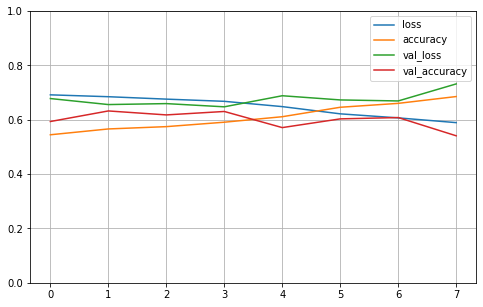


2023-03-26 18:53:10.430314

Testing # 1 1
2023-03-26 18:53:10.430412
2023-03-26 18:53:10.430444
PREDICT
2023-03-26 18:53:10.705535
Test 1:0 619:409 60.21%
Predict 1:0 397:631 38.62%
Test sizes (1028, 4997) (1028,)
Range of scores: 0.019878168 to 0.9391666
Score threshold 0.5
Confusion matrix
 [[284 125]
 [347 272]]
Normalized matrix
 [[0.27626459 0.12159533]
 [0.33754864 0.26459144]]


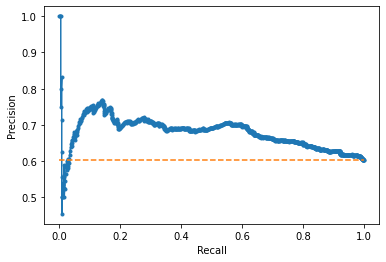

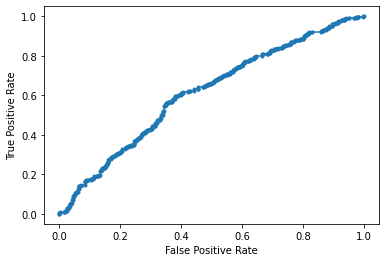

Accuracy: 54.09% Precision: 68.51% Recall: 43.94%
F1: 53.54% MCC: 0.1345
AUPRC: 67.95% AUROC: 61.32%
 accuracy [54.08560311284047]
 precision [68.51385390428212]
 recall [43.94184168012924]
 F1 [53.54330708661418]
 MCC [0.13450448024419367]
 AUPRC [67.95363859505326]
 AUROC [61.319029430700986]
2023-03-26 18:53:12.099811

Training # 1 2
2023-03-26 18:53:12.101090
2023-03-26 18:53:12.101146
Discriminator ZERO -1
Train 1:0 2389:1722 58.11%
Computed class weights: {0: 1.193670150987224, 1: 0.8604018417748012}
Valid 1:0 588:440 57.20%
FIT
2023-03-26 18:53:13.514095


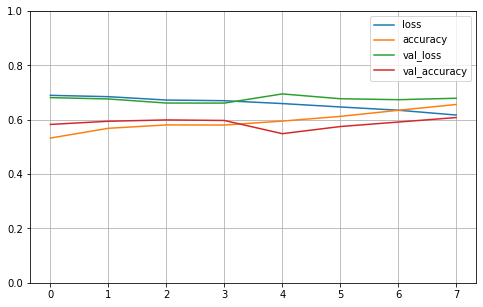


2023-03-26 18:53:35.373362

Testing # 1 2
2023-03-26 18:53:35.373456
2023-03-26 18:53:35.373491
PREDICT
2023-03-26 18:53:35.639199
Test 1:0 588:440 57.20%
Predict 1:0 803:225 78.11%
Test sizes (1028, 4997) (1028,)
Range of scores: 0.05887324 to 0.8974849
Score threshold 0.5
Confusion matrix
 [[131 309]
 [ 94 494]]
Normalized matrix
 [[0.12743191 0.30058366]
 [0.09143969 0.48054475]]


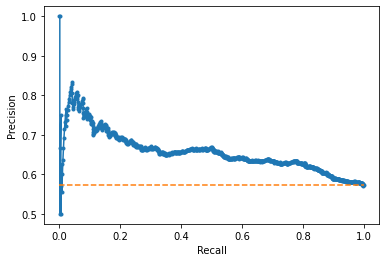

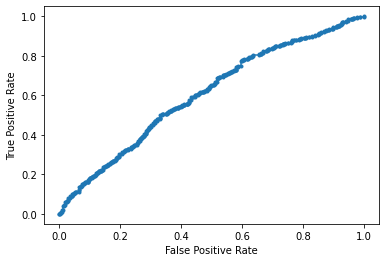

Accuracy: 60.80% Precision: 61.52% Recall: 84.01%
F1: 71.03% MCC: 0.1650
AUPRC: 65.68% AUROC: 60.61%
 accuracy [60.7976653696498]
 precision [61.51930261519303]
 recall [84.01360544217688]
 F1 [71.02803738317756]
 MCC [0.16497370387675442]
 AUPRC [65.68360424955146]
 AUROC [60.61417748917749]
2023-03-26 18:53:36.923408

Training # 1 3
2023-03-26 18:53:36.924180
2023-03-26 18:53:36.924233
Discriminator ZERO -1
Train 1:0 2381:1730 57.92%
Computed class weights: {0: 1.188150289017341, 1: 0.863292734145317}
Valid 1:0 596:432 57.98%
FIT
2023-03-26 18:53:38.339495


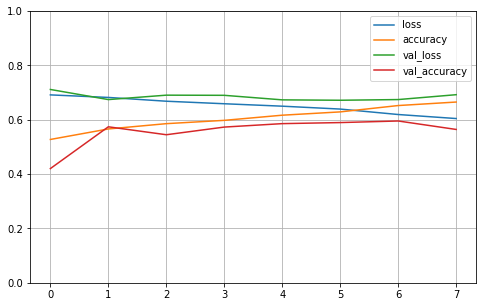


2023-03-26 18:54:00.176181

Testing # 1 3
2023-03-26 18:54:00.176304
2023-03-26 18:54:00.176342
PREDICT
2023-03-26 18:54:00.449124
Test 1:0 596:432 57.98%
Predict 1:0 546:482 53.11%
Test sizes (1028, 4997) (1028,)
Range of scores: 0.029225504 to 0.94827974
Score threshold 0.5
Confusion matrix
 [[233 199]
 [249 347]]
Normalized matrix
 [[0.2266537  0.19357977]
 [0.2422179  0.33754864]]


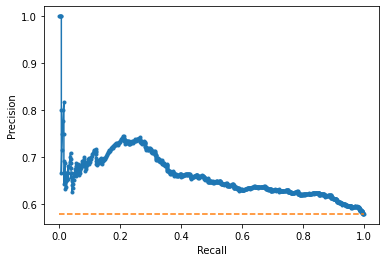

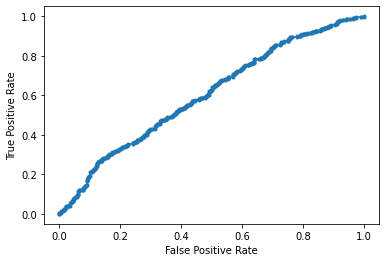

Accuracy: 56.42% Precision: 63.55% Recall: 58.22%
F1: 60.77% MCC: 0.1202
AUPRC: 66.00% AUROC: 60.40%
 accuracy [56.42023346303502]
 precision [63.55311355311355]
 recall [58.22147651006711]
 F1 [60.77057793345008]
 MCC [0.12024291435390295]
 AUPRC [66.00317695834043]
 AUROC [60.40074260502113]
2023-03-26 18:54:01.729198

Training # 1 4
2023-03-26 18:54:01.730977
2023-03-26 18:54:01.731034
Discriminator ZERO -1
Train 1:0 2407:1704 58.55%
Computed class weights: {0: 1.2062793427230047, 1: 0.853967594515995}
Valid 1:0 570:458 55.45%
FIT
2023-03-26 18:54:03.164321


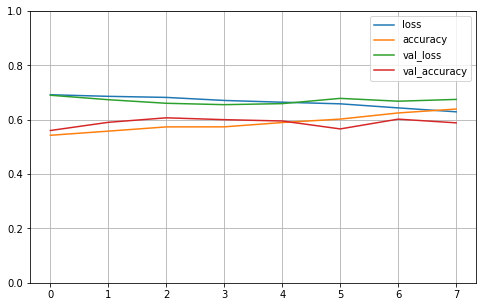


2023-03-26 18:54:24.978054

Testing # 1 4
2023-03-26 18:54:24.978466
2023-03-26 18:54:24.978508
PREDICT
2023-03-26 18:54:25.261403
Test 1:0 570:458 55.45%
Predict 1:0 679:349 66.05%
Test sizes (1028, 4997) (1028,)
Range of scores: 0.10860935 to 0.9250593
Score threshold 0.5
Confusion matrix
 [[192 266]
 [157 413]]
Normalized matrix
 [[0.18677043 0.25875486]
 [0.15272374 0.40175097]]


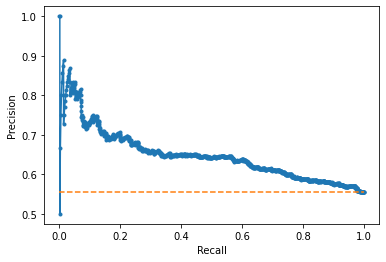

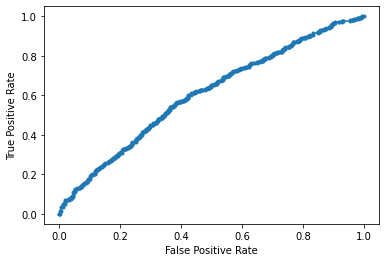

Accuracy: 58.85% Precision: 60.82% Recall: 72.46%
F1: 66.13% MCC: 0.1509
AUPRC: 64.87% AUROC: 60.58%
 accuracy [58.85214007782101]
 precision [60.824742268041234]
 recall [72.45614035087719]
 F1 [66.13290632506005]
 MCC [0.1509061996588284]
 AUPRC [64.87454749625932]
 AUROC [60.57956025434766]
2023-03-26 18:54:26.424024

Training # 1 5
2023-03-26 18:54:26.425602
2023-03-26 18:54:26.425657
Discriminator ZERO -1
Train 1:0 2373:1739 57.71%
Computed class weights: {0: 1.1822886716503738, 1: 0.8664138221660346}
Valid 1:0 604:423 58.81%
FIT
2023-03-26 18:54:27.830666


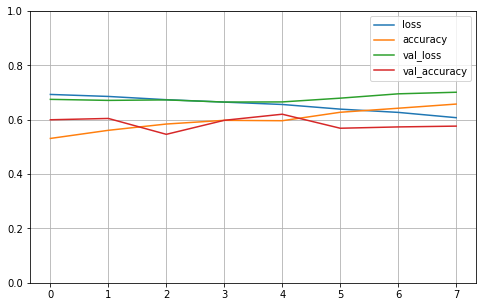


2023-03-26 18:54:49.726910

Testing # 1 5
2023-03-26 18:54:49.728456
2023-03-26 18:54:49.728814
PREDICT
2023-03-26 18:54:50.260342
Test 1:0 604:423 58.81%
Predict 1:0 625:402 60.86%
Test sizes (1027, 4997) (1027,)
Range of scores: 0.04766458 to 0.9530674
Score threshold 0.5
Confusion matrix
 [[195 228]
 [207 397]]
Normalized matrix
 [[0.18987342 0.22200584]
 [0.20155794 0.3865628 ]]


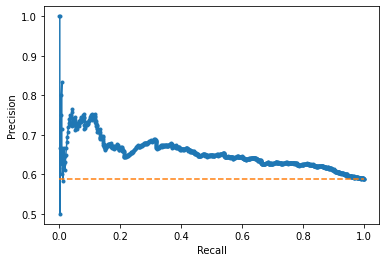

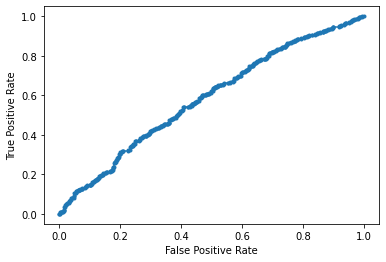

Accuracy: 57.64% Precision: 63.52% Recall: 65.73%
F1: 64.61% MCC: 0.1193
AUPRC: 65.34% AUROC: 58.59%
 accuracy [57.64362220058422]
 precision [63.519999999999996]
 recall [65.72847682119205]
 F1 [64.60537021969081]
 MCC [0.11927197218560254]
 AUPRC [65.34009863136905]
 AUROC [58.59204984891895]
2023-03-26 18:54:51.706791

Training # 2 1
2023-03-26 18:54:51.706968
2023-03-26 18:54:51.707015
Discriminator ZERO -1
Train 1:0 2380:1731 57.89%
Computed class weights: {0: 1.1874638937030617, 1: 0.863655462184874}
Valid 1:0 597:431 58.07%
FIT
2023-03-26 18:54:53.128994


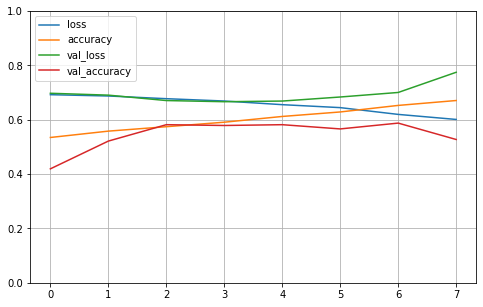


2023-03-26 18:55:15.078685

Testing # 2 1
2023-03-26 18:55:15.080145
2023-03-26 18:55:15.080467
PREDICT
2023-03-26 18:55:15.609178
Test 1:0 597:431 58.07%
Predict 1:0 319:709 31.03%
Test sizes (1028, 4997) (1028,)
Range of scores: 0.019149756 to 0.9383154
Score threshold 0.5
Confusion matrix
 [[327 104]
 [382 215]]
Normalized matrix
 [[0.31809339 0.10116732]
 [0.37159533 0.20914397]]


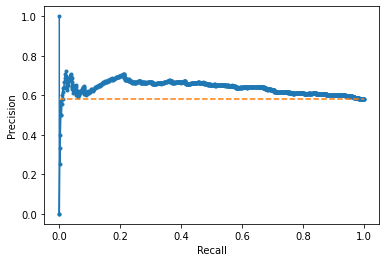

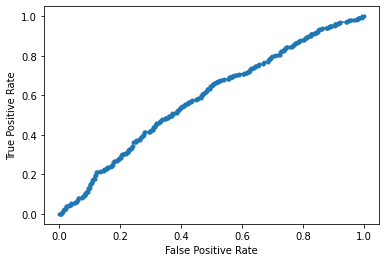

Accuracy: 52.72% Precision: 67.40% Recall: 36.01%
F1: 46.94% MCC: 0.1268
AUPRC: 63.81% AUROC: 58.84%
 accuracy [52.723735408560316]
 precision [67.39811912225704]
 recall [36.01340033500838]
 F1 [46.943231441048034]
 MCC [0.12675077209227986]
 AUPRC [63.811465756915176]
 AUROC [58.83594305634902]
2023-03-26 18:55:16.996580

Training # 2 2
2023-03-26 18:55:16.996839
2023-03-26 18:55:16.996896
Discriminator ZERO -1
Train 1:0 2361:1750 57.43%
Computed class weights: {0: 1.1745714285714286, 1: 0.8706056755612028}
Valid 1:0 616:412 59.92%
FIT
2023-03-26 18:55:18.551453


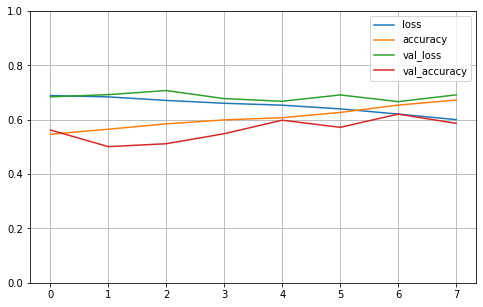


2023-03-26 18:55:40.357101

Testing # 2 2
2023-03-26 18:55:40.357639
2023-03-26 18:55:40.357676
PREDICT
2023-03-26 18:55:40.665176
Test 1:0 616:412 59.92%
Predict 1:0 541:487 52.63%
Test sizes (1028, 4997) (1028,)
Range of scores: 0.017494528 to 0.89554745
Score threshold 0.5
Confusion matrix
 [[237 175]
 [250 366]]
Normalized matrix
 [[0.23054475 0.17023346]
 [0.24319066 0.35603113]]


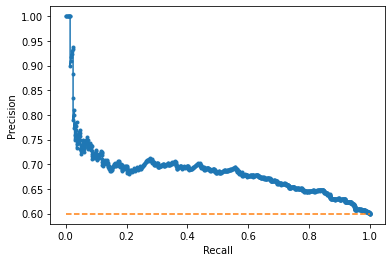

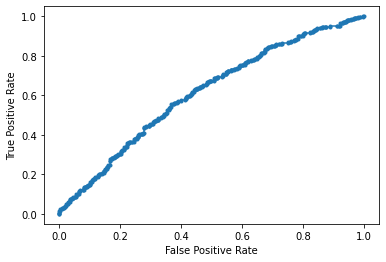

Accuracy: 58.66% Precision: 67.65% Recall: 59.42%
F1: 63.27% MCC: 0.1663
AUPRC: 68.50% AUROC: 61.32%
 accuracy [58.65758754863813]
 precision [67.65249537892791]
 recall [59.41558441558441]
 F1 [63.26707000864303]
 MCC [0.16625915612098285]
 AUPRC [68.49998451203044]
 AUROC [61.315959525910976]
2023-03-26 18:55:42.186301

Training # 2 3
2023-03-26 18:55:42.188303
2023-03-26 18:55:42.188695
Discriminator ZERO -1
Train 1:0 2386:1725 58.04%
Computed class weights: {0: 1.1915942028985507, 1: 0.8614836546521375}
Valid 1:0 591:437 57.49%
FIT
2023-03-26 18:55:44.495768


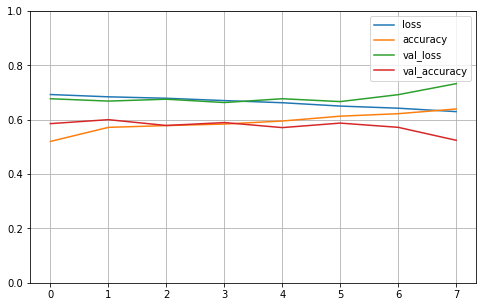


2023-03-26 18:56:01.282250

Testing # 2 3
2023-03-26 18:56:01.282359
2023-03-26 18:56:01.282398
PREDICT
2023-03-26 18:56:01.554069
Test 1:0 591:437 57.49%
Predict 1:0 294:734 28.60%
Test sizes (1028, 4997) (1028,)
Range of scores: 0.046092443 to 0.8961849
Score threshold 0.5
Confusion matrix
 [[341  96]
 [393 198]]
Normalized matrix
 [[0.33171206 0.09338521]
 [0.38229572 0.192607  ]]


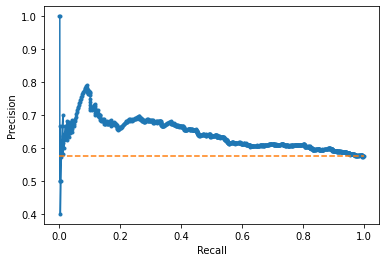

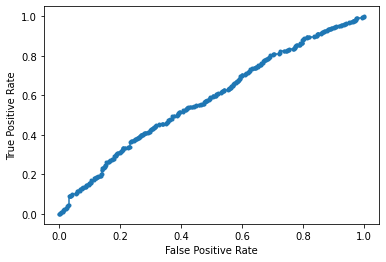

Accuracy: 52.43% Precision: 67.35% Recall: 33.50%
F1: 44.75% MCC: 0.1262
AUPRC: 64.20% AUROC: 58.13%
 accuracy [52.431906614785994]
 precision [67.3469387755102]
 recall [33.50253807106599]
 F1 [44.74576271186441]
 MCC [0.1261869226164036]
 AUPRC [64.19813970713355]
 AUROC [58.134024091347335]
2023-03-26 18:56:02.871232

Training # 2 4
2023-03-26 18:56:02.871398
2023-03-26 18:56:02.871442
Discriminator ZERO -1
Train 1:0 2397:1714 58.31%
Computed class weights: {0: 1.1992415402567094, 1: 0.8575302461410096}
Valid 1:0 580:448 56.42%
FIT
2023-03-26 18:56:04.265686


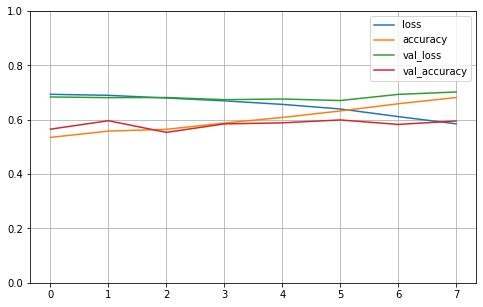


2023-03-26 18:56:21.163629

Testing # 2 4
2023-03-26 18:56:21.165529
2023-03-26 18:56:21.165916
PREDICT
2023-03-26 18:56:21.694214
Test 1:0 580:448 56.42%
Predict 1:0 664:364 64.59%
Test sizes (1028, 4997) (1028,)
Range of scores: 0.020944756 to 0.9650446
Score threshold 0.5
Confusion matrix
 [[198 250]
 [166 414]]
Normalized matrix
 [[0.192607   0.24319066]
 [0.1614786  0.40272374]]


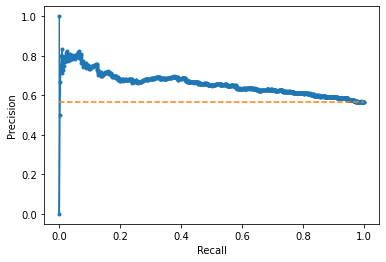

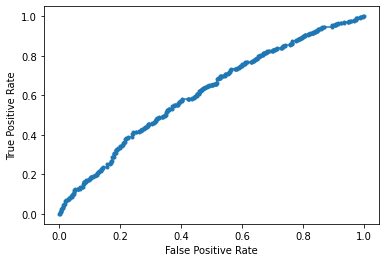

Accuracy: 59.53% Precision: 62.35% Recall: 71.38%
F1: 66.56% MCC: 0.1615
AUPRC: 65.86% AUROC: 61.36%
 accuracy [59.53307392996109]
 precision [62.34939759036144]
 recall [71.37931034482759]
 F1 [66.55948553054662]
 MCC [0.16149791920814174]
 AUPRC [65.85997397752313]
 AUROC [61.35621921182266]
2023-03-26 18:56:23.260537

Training # 2 5
2023-03-26 18:56:23.260743
2023-03-26 18:56:23.260792
Discriminator ZERO -1
Train 1:0 2384:1728 57.98%
Computed class weights: {0: 1.1898148148148149, 1: 0.8624161073825504}
Valid 1:0 593:434 57.74%
FIT
2023-03-26 18:56:24.996610


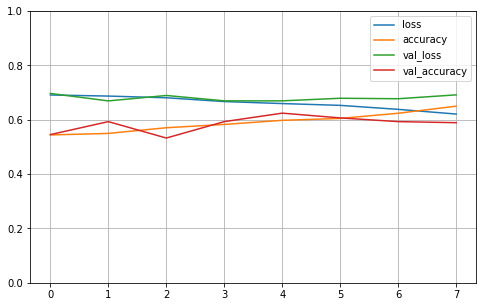


2023-03-26 18:56:42.028390

Testing # 2 5
2023-03-26 18:56:42.028499
2023-03-26 18:56:42.028536
PREDICT
2023-03-26 18:56:42.315250
Test 1:0 593:434 57.74%
Predict 1:0 625:402 60.86%
Test sizes (1027, 4997) (1027,)
Range of scores: 0.013445967 to 0.9690039
Score threshold 0.5
Confusion matrix
 [[207 227]
 [195 398]]
Normalized matrix
 [[0.20155794 0.22103213]
 [0.18987342 0.38753651]]


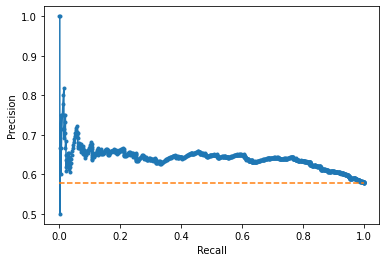

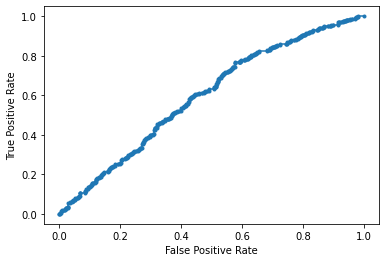

Accuracy: 58.91% Precision: 63.68% Recall: 67.12%
F1: 65.35% MCC: 0.1499
AUPRC: 64.09% AUROC: 59.77%
 accuracy [58.90944498539435]
 precision [63.68000000000001]
 recall [67.11635750421586]
 F1 [65.35303776683087]
 MCC [0.14991291122107014]
 AUPRC [64.08824720333658]
 AUROC [59.768341868651945]
2023-03-26 18:56:42.999294


In [11]:
print(datetime.now())

accuracy=[]
precision=[]
recall=[]
f1=[]
mcc=[]
auprc=[]
auroc=[]

loader = DataLoader()
filepath = DATA_DIR+RCI_FILE_TRAIN
print("Load RCI from",filepath)
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
filepath = DATA_DIR+SEQ_FILE_TRAIN
print('Load sequence from',filepath)
allids,allseq = loader.load_sequence(filepath)
print('Loaded',len(allseq),'sequences.')
test_gene_to_rci = None
test_allids = None
test_allseq = None
if SEQ_FILE_TEST is not None:
    # Train on the entire train set (no cross-validation).
    # Evaluate with the test files.
    test_loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE_TEST
    print("Load RCI from",filepath)
    test_gene_to_rci = test_loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(test_gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TEST
    print('Load sequence from',filepath)
    test_allids,test_allseq = test_loader.load_sequence(filepath)
    print('Loaded',len(test_allseq),'sequences.')

REPEATS = 2
FOLDS = 5
for repeat in range(REPEATS):
    for fold in range(FOLDS):
        r = repeat+1
        f = fold+1

        if SEQ_FILE_TEST is None:
            # Train on 80% and evaluate on 20%.
            separator = Separator()
            separator.load(DATA_DIR,r,f)
            separator.process(allids,allseq,gene_to_rci)
            train_allids,test_allids = separator.get_ids()
            train_allseq,test_allseq = separator.get_seq()
            train_gene_to_rci,test_gene_to_rci = separator.get_rci()
        else:
            # Train on the entire train set (no cross-validation).
            # Evaluate with the test files.
            train_allids = allids
            train_allseq = allseq
            train_gene_to_rci = gene_to_rci
            test_allids = None
            test_allseq = None
            test_gene_to_rci = None
            
        print(datetime.now())
        print()
        print("Training #",r,f)
        print(datetime.now())
        cvdo = CrossValidator(EPOCHS,BREAK)
        cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
        cvdo.train_new_model(
            train_allids,train_allseq,train_gene_to_rci,
            test_allids,test_allseq,test_gene_to_rci)
           
        print()
        print(datetime.now())
        print()
        print("Testing #",r,f)
        print(datetime.now())
        cvdo.reset_statistics()
        cvdo.test_without_training(
            test_allids,test_allseq,test_gene_to_rci)
        cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
            cvdo.get_statistics()

        print(" accuracy" ,  cv_accuracy)
        print(" precision" , cv_precision)
        print(" recall" ,    cv_recall)
        print(" F1" ,        cv_f1)
        print(" MCC" ,       cv_mcc)
        print(" AUPRC" ,     cv_auprc)
        print(" AUROC" ,     cv_auroc)

        accuracy.append(cv_accuracy)
        precision.append(cv_precision)
        recall.append(cv_recall)
        f1.append(cv_f1)
        mcc.append(cv_mcc)
        auprc.append(cv_auprc)
        auroc.append(cv_auroc)
        if BREAK: break
    if BREAK: break
print(datetime.now())

In [12]:
def STD (values):
    return np.std(values,ddof=1)

print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
print(" MCC mean %.2f%% std %.2f" %       (np.mean(mcc),       STD(mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

print(" accuracy"  , accuracy)
print(" precision" , precision)
print(" recall"    , recall)
print(" F1"        , f1)
print(" MCC"       , mcc)
print(" AUPRC"     , auprc)
print(" AUROC"     , auroc)



 accuracy mean 57.01% std 2.96
 precision mean 64.64% std 2.83
 recall mean 59.18% std 16.59
 F1 mean 60.29% std 8.87
 MCC mean 0.14% std 0.02
 AUPRC mean 65.63% std 1.57
 AUROC mean 60.09% std 1.20
 accuracy [[54.08560311284047], [60.7976653696498], [56.42023346303502], [58.85214007782101], [57.64362220058422], [52.723735408560316], [58.65758754863813], [52.431906614785994], [59.53307392996109], [58.90944498539435]]
 precision [[68.51385390428212], [61.51930261519303], [63.55311355311355], [60.824742268041234], [63.519999999999996], [67.39811912225704], [67.65249537892791], [67.3469387755102], [62.34939759036144], [63.68000000000001]]
 recall [[43.94184168012924], [84.01360544217688], [58.22147651006711], [72.45614035087719], [65.72847682119205], [36.01340033500838], [59.41558441558441], [33.50253807106599], [71.37931034482759], [67.11635750421586]]
 F1 [[53.54330708661418], [71.02803738317756], [60.77057793345008], [66.13290632506005], [64.60537021969081], [46.943231441048034], [63.2